In [1]:
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Input, Add, Activation, Dropout
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)


def DC_CNN_Block(nb_filter, filter_length, dilation):
    def f(input_):
        residual =    input_
        layer_out =   Conv1D(
            filters=nb_filter, kernel_size=filter_length, 
            dilation_rate=dilation, 
            activation='linear', padding='causal', use_bias=False
        )(input_)                    
        layer_out =   Activation('selu')(layer_out)        
        skip_out =    Conv1D(1, 1, activation='linear', use_bias=False)(layer_out)        
        network_in =  Conv1D(1, 1, activation='linear', use_bias=False)(layer_out)                      
        network_out = Add()([residual, network_in])        
        return network_out, skip_out    
    return f


def DC_CNN_Model(length):
    input = Input(shape=(length,1))
    l1a, l1b = DC_CNN_Block(32, 2, 1)(input)    
    l2a, l2b = DC_CNN_Block(32, 2, 2)(l1a) 
    l3a, l3b = DC_CNN_Block(32, 2, 4)(l2a)
    l4a, l4b = DC_CNN_Block(32, 2, 8)(l3a)
    l5a, l5b = DC_CNN_Block(32, 2, 16)(l4a)
    l6a, l6b = DC_CNN_Block(32, 2, 32)(l5a)
    l6b = Dropout(0.8)(l6b)
    l7a, l7b = DC_CNN_Block(32, 2, 64)(l6a)
    l7b = Dropout(0.8)(l7b)
    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    l9 =   Activation('relu')(l8)   
    l21 =  Conv1D(1, 1, activation='linear', use_bias=False)(l9)
    model = Model(inputs=input, outputs=l21)
    model.compile(loss='mae', optimizer=optimizers.adam_v2.Adam(), metrics=['mse'])
    return model

In [2]:
def fit_model(timeseries):
    length = len(timeseries)-1
    model = DC_CNN_Model(length)
    model.summary()
    X = timeseries[:-1].reshape(1,length, 1)
    y = timeseries[1:].reshape(1,length, 1)
    model.fit(X, y, epochs=3000, callbacks=[callback])
    return model
    
def forecast(model, timeseries, horizon: int):
    length = len(timeseries)-1
    pred_array = np.zeros(horizon).reshape(1, horizon, 1)
    X_test_initial = timeseries[1:].reshape(1,length,1)
    
    pred_array[: ,0, :] = model.predict(X_test_initial)[:, -1:, :]
    for i in range(horizon-1):
        pred_array[:, i+1:, :] = model.predict(
            np.append(
                X_test_initial[:, i+1:, :], 
                pred_array[:, :i+1, :]
            ).reshape(1, length, 1))[:, -1:, :]
    return pred_array.flatten()
    
def evaluate_timeseries(series, horizon: int):
    model = fit_model(series)
    pred_array = forecast(model, series, horizon)
    return pred_array, model

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def show_result(y_test, predicted, ylabel="Passengers"):
  plt.figure(figsize=(16, 6))
  plt.plot(y_test.index, predicted, 'o-', label="predicted")
  plt.plot(y_test.index, y_test, '.-', label="actual")

  plt.ylabel(ylabel)
  plt.legend()

In [4]:
import pandas as pd

values = [         
  112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
  141., 135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
  172., 178., 199., 199., 184., 162., 146., 166., 171., 180., 193., 181., 183., 218.,
  230., 242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264., 272.,
  237., 211., 180., 201., 204., 188., 235., 227., 234., 264., 302., 293., 259., 229.,
  203., 229., 242., 233., 267., 269., 270., 315., 364., 347., 312., 274., 237., 278.,
  284., 277., 317., 313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301.,
  356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318., 362., 348.,
  363., 435., 491., 505., 404., 359., 310., 337., 360., 342., 406., 396., 420., 472.,
  548., 559., 463., 407., 362., 405., 417., 391., 419., 461., 472., 535., 622., 606.,
  508., 461., 390., 432.,
 ]
idx = pd.date_range("1949-01-01", periods=len(values), freq="M")
passengers = pd.Series(values, index=idx, name="passengers").to_frame()

In [5]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    passengers.passengers, passengers.passengers.shift(-1), shuffle=False
)
HORIZON = len(y_test)
predictions, model = evaluate_timeseries(X_train.values.reshape(-1, 1), horizon=HORIZON)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 107, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 107, 32)      64          ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 107, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 107, 1)       32          ['activation[0][0]']             
                                                                                              

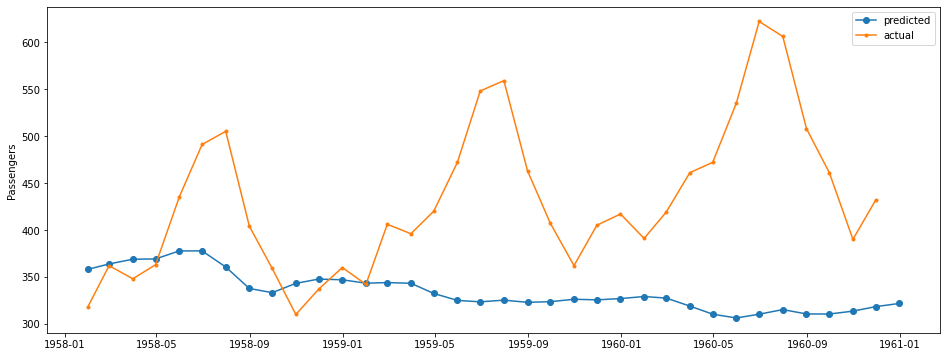

In [6]:
show_result(y_test[:HORIZON], predictions[:HORIZON], "Passengers")